<a href="https://colab.research.google.com/github/liquidx/ml/blob/main/Mobile_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A notebook to practice building a GAN for mobile screenshots based on:

* [ncoop57/rico_captions](https://huggingface.co/datasets/ncoop57/rico_captions)
* https://youtu.be/AALBGpLbj6Q
* https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

To read:
* https://www.tensorflow.org/tutorials/generative/dcgan


Saving & Loading Checkpoints
* https://machinelearningmastery.com/check-point-deep-learning-models-keras/
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb



## 1 Dependencies

In [4]:
!pip -q install datasets transformers pillow rich 

     |████████████████████████████████| 365 kB 4.6 MB/s 
     |████████████████████████████████| 4.7 MB 53.3 MB/s 
     |████████████████████████████████| 235 kB 71.3 MB/s 
     |████████████████████████████████| 141 kB 50.9 MB/s 
     |████████████████████████████████| 101 kB 11.4 MB/s 
     |████████████████████████████████| 212 kB 44.9 MB/s 
     |████████████████████████████████| 115 kB 60.3 MB/s 
     |████████████████████████████████| 596 kB 61.9 MB/s 
     |████████████████████████████████| 127 kB 71.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
     |████████████████████████████████| 51 kB 5.6 MB/s 


In [5]:
import os
import numpy as np
import PIL
import PIL.Image
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

from datasets import load_dataset
from datasets import Image
from rich import inspect
from transformers import DataCollatorWithPadding


In [1]:
HAS_COLAB = False
try:
  import google.colab
  HAS_COLAB = True
except ImportError:
  pass


In [39]:
CHECKPOINTS_DIR = './checkpoints'
if HAS_COLAB:
  google.colab.drive.mount('/content/drive')
  CHECKPOINTS_DIR = '/content/drive/MyDrive/ML/checkpoints/mobilegan'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 Initialize

In [6]:
# Bringing in tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpus    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:

seed = 123
image_size = (64, 32)
channels = 3
latent_vector_z = 100

batch_size = 128
buffer_size = 50000
prefetch_size = 64

## 3 Load Dataset

In [8]:
rico_dataset = load_dataset("ncoop57/rico_captions", split="train")

# Convert to TensorFlow compat data set
# rico_dataset_tf = rico_dataset.to_tf_dataset(columns=['screenshot_path'], batch_size=batch_size, shuffle=True)

# Load images and normalize using HF Datasets
# This is hugely inefficient since it tries to load them all rather than only
# when we use them.
# def hfd_load_image_and_normalize(row):
#   img = tf.keras.utils.load_img(row['screenshot_path'], 
#                                 grayscale=False, 
#                                 color_mode='rgb', 
#                                 target_size=image_size)
#   data = tf.keras.preprocessing.image.img_to_array(img)
#   row['image'] = data / 255.0
#   return row

# rico_dataset = rico_dataset.map(hfd_load_image_and_normalize)


Generating train split: 0 examples [00:00, ? examples/s]

Dataset rico_captions downloaded and prepared to /root/.cache/huggingface/datasets/ncoop57___rico_captions/screenshots_captions_filtered/1.1.0/6cc0546713955bddd15fe67b51242fc34d6aed4607c7d267d80f83204506db1e. Subsequent calls will reuse this data.


In [9]:
# Loading using standard keras utils

def scale_images(image):
  """Normalize RGB values to 0-1"""
  return image / 255.0


def load_using_keras_dataset(dirname):
  """
  This will already do batching/shuffling/prefetch
  https://github.com/keras-team/keras/blob/v2.9.0/keras/utils/image_dataset.py#L29-L235
  """
  ds = image_dataset_from_directory(dirname, 
                                    labels=None,
                                    color_mode="rgb",
                                    shuffle=True,
                                    image_size=image_size,
                                    batch_size=batch_size)
  return ds.map(scale_images)
  
#
# Functions for loading manually from the paths.
#

def load_image_and_normalize(path):
  print(path.eval())
  img = tf.keras.utils.load_img(path, grayscale=False, color_mode='rgb', target_size=image_size)
  data = tf.keras.preprocessing.image.img_to_array(img)
  return data / 255.0

def load_manually(dataset):
  ds = dataset
  ds = ds.map(load_image_and_normalize)
  # The dataset is already batched and shuffled
  ds = ds.cache()
  ds = ds.shuffle(buffer_size)
  # Batches 128 images per sample
  ds = ds.batch(batch_size)
  # Reduces bottlenecking
  ds = ds.prefetch(prefetch_size)
  return ds


In [10]:
screenshot_dir = os.path.dirname(rico_dataset[0]["screenshot_path"])
ds = load_using_keras_dataset(screenshot_dir)
# ds = load_manually(rico_dataset)

Found 24598 files belonging to 1 classes.


In [11]:
ds.take(1).element_spec

TensorSpec(shape=(None, 64, 32, 3), dtype=tf.float32, name=None)

## 4 Inspect Dataset

(128, 64, 32, 3)


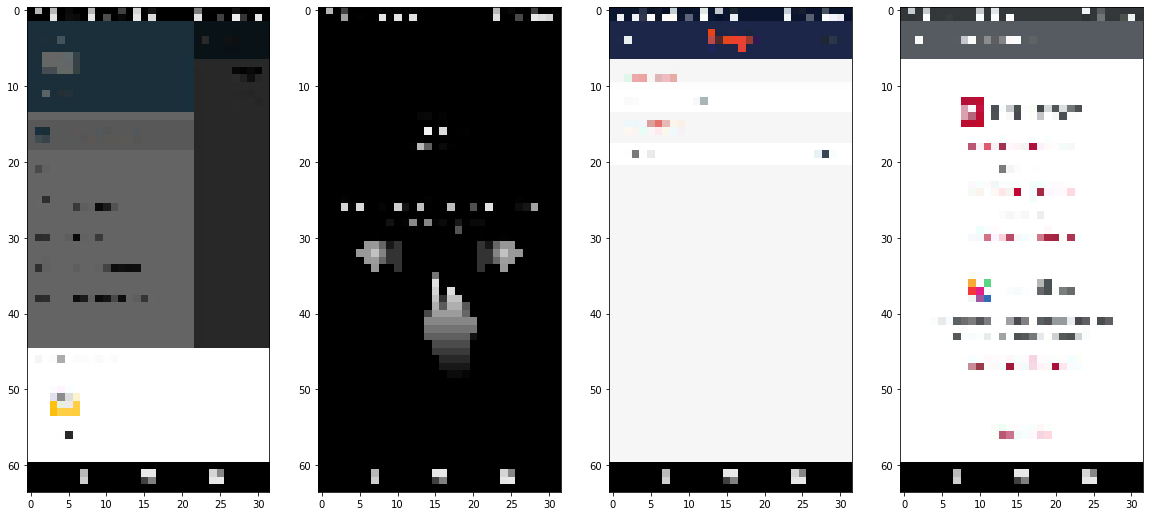

In [12]:
# Quick wat to visualize
data_iterator = ds.as_numpy_iterator()
plot_count = 4
fig, ax = plt.subplots(ncols=plot_count, figsize=(20, 10))
# gets a batch (which will be batch size)
batch = data_iterator.next()
print(batch.shape)

for i in range(plot_count):
  ax[i].imshow(np.squeeze(batch[i]))


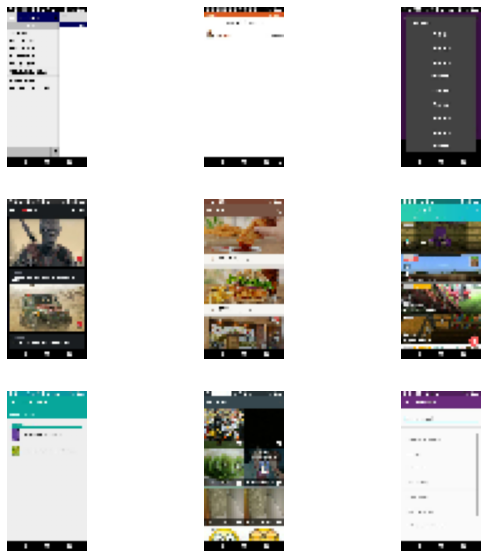

In [13]:
# Visualize what we've loaded
plt.figure(figsize=(10, 10))
for images in ds.take(1):  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(images[i].numpy().astype("uint8"))
    plt.imshow(images[i].numpy())
    plt.axis("off")

## 5. Generator

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model

# For subclassing
from tensorflow.keras.models import Model
# For ModelMonitor Callback
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback



In [15]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

def build_generator_c2(latent_dim):
  """
  The generator will go from 8x4 to 16x8 to 32x16 to 64x32.

  """
  model = Sequential()

  n = 256 
  n_nodes = n * 8 * 4

  # First hidden layer has enough nodes to represent a low
  # rest version of the output image.
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 4, n)))

  # Upsample from 8x4 to 16x8
  model.add(Conv2DTranspose(n, (8, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))


  # Upsample from 16x8 to 32x16
  model.add(Conv2DTranspose(n, (8, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample from 32x16 to 64x32
  model.add(Conv2DTranspose(n, (8, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
  return model


In [16]:
def build_generator(latent_dim):
  """
  Generator from https://youtu.be/AALBGpLbj6Q

  This is imilar to the other generator but it
  contains some extra layers to do convolutions.
  """
  model = Sequential()

  # First hidden layer has enough nodes to represent a low
  # rest version of the output image.
  n = 256 
  n_nodes = n * 8 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 4, n)))

  # Upsampling Block 1
  # Upsampling the lower res to a higher res (deconvolution)
  model.add(UpSampling2D())
  model.add(Conv2D(n, 5, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsampling Block 2
  model.add(UpSampling2D())
  model.add(Conv2D(n, 5, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

 # Upsampling Block 3
  model.add(UpSampling2D())
  model.add(Conv2D(n, 4, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Convolution block 1
  # Only in Nicholas' tutorial
  model.add(Conv2D(n, 4, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Convolution block 2
  # Only in Nicholas' tutorial
  model.add(Conv2D(n, 4, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
  return model


In [17]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [18]:
def generate_fake_samples(generator_model, latent_dim, img_count):
  seed = generate_latent_points(latent_dim, img_count)
  imgs = generator_model.predict(seed)
  return imgs

In [19]:
def generate_and_show(g_model):
  img_count = 4
  imgs = generate_fake_samples(g_model, latent_dim, img_count)
  fig, ax = plt.subplots(ncols=img_count, figsize=(20, 10))
  for i, img in enumerate(imgs):
    ax[i].imshow(np.squeeze(img))



## 6. Discriminator

In [20]:
def build_discriminator(in_shape=(64, 32, 3)):
  model = Sequential()

  # Normal
  model.add(Conv2D(64, 5, input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4)) 

  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))


  model.add(Conv2D(256, 8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4)) 
  model.add(Dense(1, activation='sigmoid'))

  return model

In [21]:

# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
def build_discriminator_c2(in_shape=(64, 32, 3)):
  model = Sequential()

  # Normal
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  # Downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Classifier
  model.add(Flatten())
  model.add(Dropout(0.4)) 
  model.add(Dense(1, activation='sigmoid'))
  return model

In [22]:
def test_discriminator():
  discriminator = build_discriminator_c2()
  #discriminator.summary()
  discriminator.predict(imgs)

## 7. GAN Model


In [32]:
class MobileGAN(Model):
  def __init__(self, generator, discriminator, latent_dim, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def compile_submodels(self):
    """Further compile the submodels manually."""
    # Because the generator is not trained, we don't need to compile it.  
    #self.generator.compile(loss=self.g_loss, optimizer=self.g_opt, metrics=['accuracy'])
    self.discriminator.compile(loss=self.d_loss, optimizer=self.d_opt, metrics=['accuracy'])


  # https://www.tensorflow.org/tutorials/generative/dcgan#define_the_training_loop
  def train_step(self, batch):
    # Get the data
    real_images = batch
    # TODO: use the common function generate_fake_data?
    fake_images = self.generator(tf.random.normal((batch_size, self.latent_dim, 1)), training=False)

    # Training : Discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # Create labels for the real and fake
      # 0 = real
      # 1 = fake
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # Add noise to the outputs.
      # Add a bit of confusion in to the discriminator to avoid it being
      # too good.
      # -0.15 is from trial and error
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))

      y_realfake += tf.concat([noise_real, noise_fake], axis=0)
                               
      # Calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # Apply backpropagation
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


    # Training : Generator
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.uniform((batch_size, self.latent_dim, 1)),training=True)
      # Generate our predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)
      # Tell the generator that we are right if the discriminator is "wrong",
      # thinks that our images are real (label = 0)
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
    return {"d_loss":total_d_loss, "g_loss":total_g_loss}
    


In [33]:
def create_gan_model(latent_dim, g_opt_learning_rate=0.0001, d_opt_learning_rate=0.00001):
  generator = build_generator_c2(latent_dim)
  #generator.summary()

  discriminator = build_discriminator_c2()
  #discriminator.summary()

  mobilegan = MobileGAN(generator, discriminator, latent_dim)

  # Setup the losses and optimizers
  g_opt = Adam(learning_rate=g_opt_learning_rate,  beta_1=0.5)
  d_opt = Adam(learning_rate=d_opt_learning_rate,  beta_1=0.5)
  g_loss = BinaryCrossentropy()
  d_loss = BinaryCrossentropy()

  mobilegan.compile(g_opt, d_opt, g_loss, d_loss)

  return mobilegan

## 8. Train

In [34]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [35]:
# From somewhere Francois?

class ModelMonitor(Callback):
  def __init__(self, initial_epoch=0, num_images=3, latent_dim=128, checkpoints_dir="checkpoints"):
    self.initial_epoch = initial_epoch
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.checkpoints_dir = checkpoints_dir

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_images, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    logical_epoch = epoch + 1
    
    for i in range(self.num_images):
      img = array_to_img(generated_images[i])
      img.save(os.path.join(self.checkpoints_dir, f'sample_{logical_epoch:02d}_{i}.png'))


In [36]:
import pickle 

class GANModelCheckpoint(Callback):
  model_weights_suffix = 'model-weights-c2.hdf5'
  training_state_filename = 'training-state.pkl'

  """ Custom implementation of a checkpointer since the GAN model is a custom model."""
  def __init__(self, initial_epoch=0, epoch_interval=1, checkpoints_dir='checkpoints'):
    self.last_epoch_saved = initial_epoch - 1
    self.epoch_interval = epoch_interval
    self.checkpoints_dir = checkpoints_dir

  def save_optimizer(self, epoch):
    output_file = os.path.join(self.checkpoints_dir, self.training_state_filename)
    with open(output_file, 'wb') as f:
      pickle.dump({
          'd_opt': self.model.d_opt.get_config(),
          'g_opt': self.model.g_opt.get_config(),
          'epoch': epoch + 1
      }, f, protocol=pickle.HIGHEST_PROTOCOL)

    print(f'Saving state to {output_file}')

  def save_model_weights(self, epoch):
    g_model = self.model.generator
    d_model = self.model.discriminator
    next_epoch = epoch + 1
    g_model.save(os.path.join(self.checkpoints_dir, f'generator-{next_epoch:02d}-{self.model_weights_suffix}'))
    d_model.save(os.path.join(self.checkpoints_dir, f'discriminator-{next_epoch:02d}-{self.model_weights_suffix}')) 
    g_model.save(os.path.join(self.checkpoints_dir, f'generator-{self.model_weights_suffix}'))
    d_model.save(os.path.join(self.checkpoints_dir, f'discriminator-{self.model_weights_suffix}'))

  def on_epoch_end(self, epoch, logs=None):
    print()
    print(f'Epoch ended: {epoch} (last saved: {self.last_epoch_saved}, interval: {self.epoch_interval})')
    should_save = False
    if epoch >= self.last_epoch_saved + self.epoch_interval:
      should_save = True

    if should_save:
      print('Saving state...')
      self.save_optimizer(epoch)
      self.save_model_weights(epoch)
      self.last_epoch_saved = epoch

  def on_train_end(self, logs=None):
    self.save_optimizer(self.params['epochs'])
    self.save_model_weights(self.params['epochs'])



In [37]:
# Create a checkpointer that we can use to resume if the training is terminated.
# Saves at every epoch
#
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

def load_weights(model, checkpoints_dir='checkpoints'):
  g_model_weights = f'generator-{GANModelCheckpoint.model_weights_suffix}'
  d_model_weights = f'discriminator-{GANModelCheckpoint.model_weights_suffix}'
  training_state_filename = GANModelCheckpoint.training_state_filename
  state = {'epoch': 0}

  training_state_path = os.path.join(checkpoints_dir, training_state_filename)
  if not os.path.exists(training_state_path):
    return state

  with open(training_state_path, 'rb') as f:
    state = pickle.load(f)
    print('Loading state', state)
    model.d_opt = Adam.from_config(state['d_opt'])
    model.g_opt = Adam.from_config(state['g_opt'])

  g_model_weights_path = os.path.join(checkpoints_dir, g_model_weights)
  if os.path.exists(g_model_weights_path):
    model.generator.load_weights(g_model_weights_path)

  d_model_weights_path = os.path.join(checkpoints_dir, d_model_weights)

  if os.path.exists(d_model_weights_path):
    model.discriminator.load_weights(d_model_weights_path)

  model.compile_submodels()

  return state


def resume_train_gan(model, 
                     initial_epoch=0, 
                     epochs=200, 
                     epochs_per_checkpoint=2, 
                     checkpoints_dir='checkpoints'):
  """Start or resume training the GAN."""
  callbacks = [
      ModelMonitor(initial_epoch=initial_epoch, 
                   checkpoints_dir=checkpoints_dir), 
      GANModelCheckpoint(initial_epoch=initial_epoch, 
                         epoch_interval=epochs_per_checkpoint, 
                         checkpoints_dir=checkpoints_dir)
  ]
  hist = model.fit(ds, epochs=epochs, initial_epoch=initial_epoch, callbacks=callbacks)  
  return hist



In [ ]:
latent_dim = 128

def start_or_resume(checkpoints_dir="checkpoints"):
  d_opt_lr = 0.00002 # learning rates
  g_opt_lr = d_opt_lr * 100
  gan_model = create_gan_model(latent_dim, 
                               g_opt_learning_rate=g_opt_lr, 
                               d_opt_learning_rate=d_opt_lr)
  state = load_weights(gan_model, checkpoints_dir=checkpoints_dir)
  hist = resume_train_gan(gan_model, 
                          initial_epoch=state['epoch'], 
                          epochs=200, 
                          epochs_per_checkpoint=5,
                          checkpoints_dir=checkpoints_dir)
  return hist

hist = start_or_resume(checkpoints_dir=CHECKPOINTS_DIR)

Epoch 1/200
 25/193 [==>...........................] - ETA: 1:23 - d_loss: 0.7571 - g_loss: 0.3886

In [146]:
def clear_history(dir):
  files = os.listdir(dir)
  for f in files:
    if f.endswith('hdf5'):
      print(f'Deleteing {f}')
      os.remove(os.path.join(dir, f))
    if f.endswith('pkl'):
      os.remove(os.path.join(dir, f))

# clear_history('.')

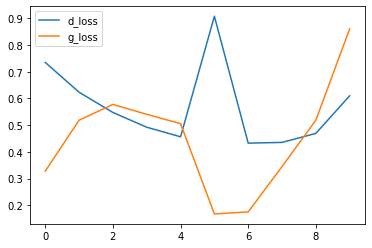

In [42]:
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

Loading state {'d_opt': {'name': 'Adam', 'learning_rate': 1e-05, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'g_opt': {'name': 'Adam', 'learning_rate': 1e-04, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'epoch': 15}


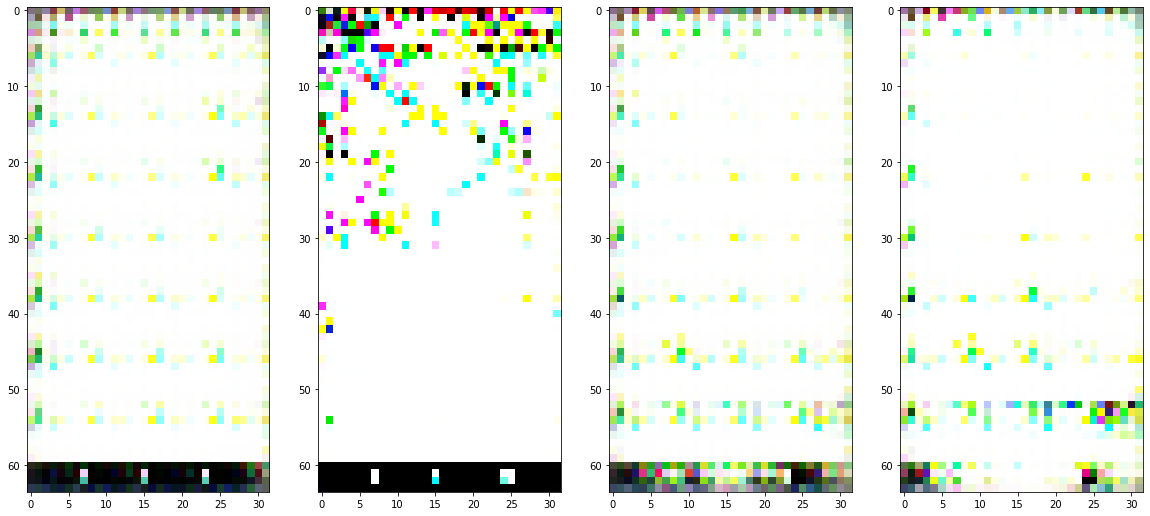

In [183]:
def test_model():
  latent_dim = 128
  gan_model = create_gan_model(latent_dim)

  checkpoints_dir = "checkpoints"
  state = load_weights(gan_model, checkpoints_dir=checkpoints_dir)

  img_count = 4
  imgs = generate_fake_samples(gan_model.generator, latent_dim, img_count)
  fig, ax = plt.subplots(ncols=img_count, figsize=(20, 10))
  for i, img in enumerate(imgs):
    ax[i].imshow(np.squeeze(img))

test_model()    

## 9. Load and Save

In [60]:
generator_model_filename = 'generator.pb'
discriminator_model_filename = 'discriminator.pb'

def reload_models(dirname):
  g_model_loaded = load_model(os.path.join(dirname, generator_model_filename))
  d_model_loaded = load_model(os.path.join(dirname, discriminator_model_filename))
  return {"discriminator": d_model_loaded, "generator": g_model_loaded}

def save_models(dirname, g_model, d_model):
  try:
    os.mkdir(dirname)
  except:
    pass

  g_model.save(os.path.join(dirname, generator_model_filename))
  d_model.save(os.path.join(dirname, discriminator_model_filename))



In [61]:
save_models('model-c2', generator, discriminator)

In [56]:
loaded = reload_models('model-c2')

In [62]:
loaded_generator = loaded["generator"]
loaded_discriminator = loaded["discriminator"]

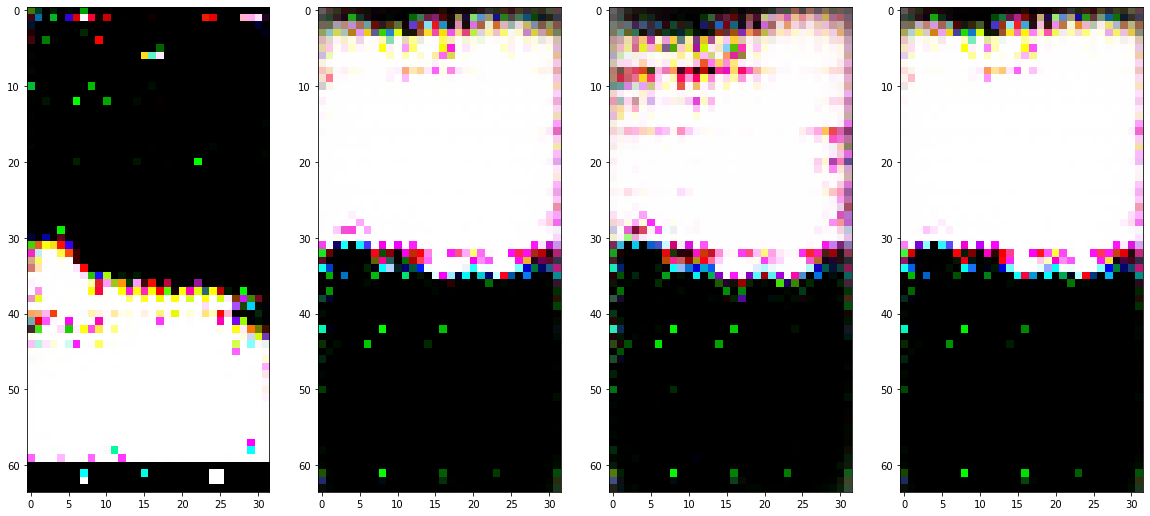

In [59]:
generate_and_show(loaded_generator)

## 10. Resume Training

In [66]:
mobilegan_resumed = MobileGAN(loaded_generator, loaded_discriminator, latent_dim)
mobilegan_resumed.compile(g_opt, d_opt, g_loss, d_loss)
hist_resumed = mobilegan_resumed.fit(ds, epochs=10, callbacks=[ModelMonitor(prefix="run_2")])

Epoch 1/10
193/193 [==============================] - 101s 498ms/step - d_loss: 0.3074 - g_loss: 1.4297
Epoch 2/10
193/193 [==============================] - 99s 494ms/step - d_loss: 0.2915 - g_loss: 1.7241
Epoch 3/10
193/193 [==============================] - 100s 499ms/step - d_loss: 0.2845 - g_loss: 1.9393
Epoch 4/10
193/193 [==============================] - 99s 496ms/step - d_loss: 0.2807 - g_loss: 2.1053
Epoch 5/10
193/193 [==============================] - 104s 519ms/step - d_loss: 0.2786 - g_loss: 2.2255
Epoch 6/10
193/193 [==============================] - 119s 600ms/step - d_loss: 0.2775 - g_loss: 2.2977
Epoch 7/10
193/193 [==============================] - 104s 522ms/step - d_loss: 0.2780 - g_loss: 2.3549
Epoch 8/10
193/193 [==============================] - 106s 529ms/step - d_loss: 0.2752 - g_loss: 2.3958
Epoch 9/10
193/193 [==============================] - 124s 622ms/step - d_loss: 0.2754 - g_loss: 2.4226
Epoch 10/10
193/193 [==============================] - 129s 638ms/

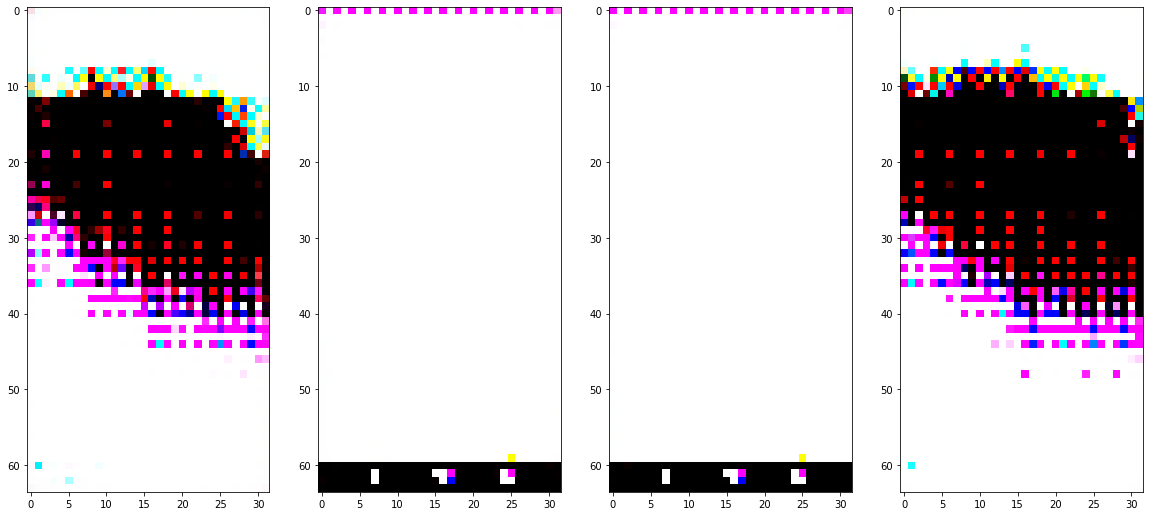

In [68]:
generate_and_show(mobilegan_resumed.generator)